In [1]:
import findspark
findspark.init()
import pyspark

In [2]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

In [3]:
appName = "Air Quality Classification in London with PySpark"
spark = SparkSession \
.builder \
.appName(appName) \
.config("spark.some.config.option", "some-value") \
.getOrCreate()
sc = spark.sparkContext

23/04/11 10:42:29 WARN Utils: Your hostname, Poojas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.100.148.65 instead (on interface en0)
23/04/11 10:42:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/11 10:42:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/11 10:42:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/04/11 10:42:42 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
# load data from file to DataFrame with schema infer
df = spark.read.options(delimiter=';', inferSchema=True, header=True) \
            .csv("/Users/sakshamtaneja/Desktop/Big-Data-Apache-Spark-Projects-master/FINAL EXAM/dataset.csv");
df.show(5)

+----------+-------------------+---+---+----+----+-------+
|      date|               time|NO2| O3|PM10|PM25|quality|
+----------+-------------------+---+---+----+----+-------+
|01/01/2008|2023-04-11 00:00:00| 96| 66|  52|  37|      0|
|01/01/2008|2023-04-11 01:00:00| 92| 66|  50|  36|      0|
|01/01/2008|2023-04-11 02:00:00| 91| 65|  50|  36|      0|
|01/01/2008|2023-04-11 03:00:00| 91| 64|  50|  36|      0|
|01/01/2008|2023-04-11 04:00:00| 91| 61|  50|  36|      0|
+----------+-------------------+---+---+----+----+-------+
only showing top 5 rows



In [5]:
# view general information of the dataset
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- NO2: integer (nullable = true)
 |-- O3: integer (nullable = true)
 |-- PM10: integer (nullable = true)
 |-- PM25: integer (nullable = true)
 |-- quality: integer (nullable = true)



In [6]:
# view statistical information from the dataset
df.describe().show()

+-------+----------+-----------------+------------------+------------------+------------------+-------------------+
|summary|      date|              NO2|                O3|              PM10|              PM25|            quality|
+-------+----------+-----------------+------------------+------------------+------------------+-------------------+
|  count|      3168|             3168|              3168|              3168|              3168|               3168|
|   mean|      null|55.75536616161616|27.190656565656564|25.119318181818183|15.717803030303031|0.47285353535353536|
| stddev|      null|13.46835991893537|10.554635449455423| 6.122290685326892| 5.202793568098651|  0.499341341995463|
|    min|01/01/2008|               21|                 6|                12|                 6|                  0|
|    max|01/12/2018|               96|                66|                52|                37|                  1|
+-------+----------+-----------------+------------------+---------------

In [7]:
from pyspark.sql.functions import udf, rand
from pyspark.sql.types import StringType, DoubleType

In [8]:
# Converts an integer to a double and converts the 'quality' column to categorical
def condition(r):
    if (r == 0):
        label = "bad"
    else:
        label = "good"
    return label

df = df.withColumn("NO2", df["NO2"].cast('double'))
df = df.withColumn("O3", df["O3"].cast('double'))
df = df.withColumn("PM10", df["PM10"].cast('double'))
df = df.withColumn("PM25", df["PM25"].cast('double'))

string_udf = udf(condition, StringType())
df = df.withColumn('quality', string_udf('quality'))

df.show(5)

+----------+-------------------+----+----+----+----+-------+
|      date|               time| NO2|  O3|PM10|PM25|quality|
+----------+-------------------+----+----+----+----+-------+
|01/01/2008|2023-04-11 00:00:00|96.0|66.0|52.0|37.0|    bad|
|01/01/2008|2023-04-11 01:00:00|92.0|66.0|50.0|36.0|    bad|
|01/01/2008|2023-04-11 02:00:00|91.0|65.0|50.0|36.0|    bad|
|01/01/2008|2023-04-11 03:00:00|91.0|64.0|50.0|36.0|    bad|
|01/01/2008|2023-04-11 04:00:00|91.0|61.0|50.0|36.0|    bad|
+----------+-------------------+----+----+----+----+-------+
only showing top 5 rows



In [9]:
# view general information of the dataset
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- NO2: double (nullable = true)
 |-- O3: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- PM25: double (nullable = true)
 |-- quality: string (nullable = true)



In [11]:
# Convert a column with data type double to vector
def get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select(indexCol,'features','label')

In [12]:
# Transforming the conversion results into a dataframe
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[2:-1]),r[-1]]).toDF(['features','label'])

In [13]:
transformed = transData(df)
transformed.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[96.0,66.0,52.0,3...|  bad|
|[92.0,66.0,50.0,3...|  bad|
|[91.0,65.0,50.0,3...|  bad|
|[91.0,64.0,50.0,3...|  bad|
|[91.0,61.0,50.0,3...|  bad|
+--------------------+-----+
only showing top 5 rows



In [14]:
# assigns an index value to the features and label column
labelIndexer = StringIndexer(inputCol='labe',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|[96.0,66.0,52.0,3...|  bad|         0.0|
|[92.0,66.0,50.0,3...|  bad|         0.0|
|[91.0,65.0,50.0,3...|  bad|         0.0|
|[91.0,64.0,50.0,3...|  bad|         0.0|
|[91.0,61.0,50.0,3...|  bad|         0.0|
+--------------------+-----+------------+
only showing top 5 rows



In [15]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|[96.0,66.0,52.0,3...|  bad|[96.0,66.0,52.0,3...|
|[92.0,66.0,50.0,3...|  bad|[92.0,66.0,50.0,3...|
|[91.0,65.0,50.0,3...|  bad|[91.0,65.0,50.0,3...|
|[91.0,64.0,50.0,3...|  bad|[91.0,64.0,50.0,3...|
|[91.0,61.0,50.0,3...|  bad|[91.0,61.0,50.0,3...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [16]:
# Dividing into training data and testing data
(trainingData, testData) = transformed.randomSplit([0.8, 0.2])

trainingData.show(5)
testData.show(5)

+-------------------+-----+
|           features|label|
+-------------------+-----+
|[22.0,7.0,12.0,6.0]| good|
|[22.0,7.0,12.0,7.0]| good|
|[23.0,7.0,12.0,7.0]| good|
|[23.0,8.0,13.0,7.0]| good|
|[24.0,8.0,13.0,7.0]| good|
+-------------------+-----+
only showing top 5 rows

+-------------------+-----+
|           features|label|
+-------------------+-----+
|[21.0,6.0,12.0,6.0]| good|
|[23.0,8.0,13.0,7.0]| good|
|[25.0,8.0,13.0,7.0]| good|
|[27.0,9.0,14.0,8.0]| good|
|[27.0,9.0,14.0,8.0]| good|
+-------------------+-----+
only showing top 5 rows



In [17]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(featuresCol='indexedFeatures', labelCol='indexedLabel')
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, nb,labelConverter])
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [18]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

23/04/11 10:56:16 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/11 10:56:16 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/04/11 10:56:16 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
+-------------------+-----+--------------+
|           features|label|predictedLabel|
+-------------------+-----+--------------+
|[21.0,6.0,12.0,6.0]| good|          good|
|[23.0,8.0,13.0,7.0]| good|          good|
|[25.0,8.0,13.0,7.0]| good|          good|
|[27.0,9.0,14.0,8.0]| good|          good|
|[27.0,9.0,14.0,8.0]| good|          good|
+-------------------+-----+--------------+
only showing top 5 rows



In [19]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.00771605


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_temp

['bad', 'good']

In [23]:
predictions.show(5)

+-------------------+-----+------------+-------------------+--------------------+--------------------+----------+--------------+
|           features|label|indexedLabel|    indexedFeatures|       rawPrediction|         probability|prediction|predictedLabel|
+-------------------+-----+------------+-------------------+--------------------+--------------------+----------+--------------+
|[21.0,6.0,12.0,6.0]| good|         1.0|[21.0,6.0,12.0,6.0]|[-58.414710088349...|[0.29224276585584...|       1.0|          good|
|[23.0,8.0,13.0,7.0]| good|         1.0|[23.0,8.0,13.0,7.0]|[-66.632745860501...|[0.33831052816493...|       1.0|          good|
|[25.0,8.0,13.0,7.0]| good|         1.0|[25.0,8.0,13.0,7.0]|[-68.274866300425...|[0.31048308414660...|       1.0|          good|
|[27.0,9.0,14.0,8.0]| good|         1.0|[27.0,9.0,14.0,8.0]|[-75.042943411772...|[0.31493258151228...|       1.0|          good|
|[27.0,9.0,14.0,8.0]| good|         1.0|[27.0,9.0,14.0,8.0]|[-75.042943411772...|[0.3149325815122

In [24]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[364,   5],
       [  0, 279]])

Confusion matrix, without normalization
[[364   5]
 [  0 279]]


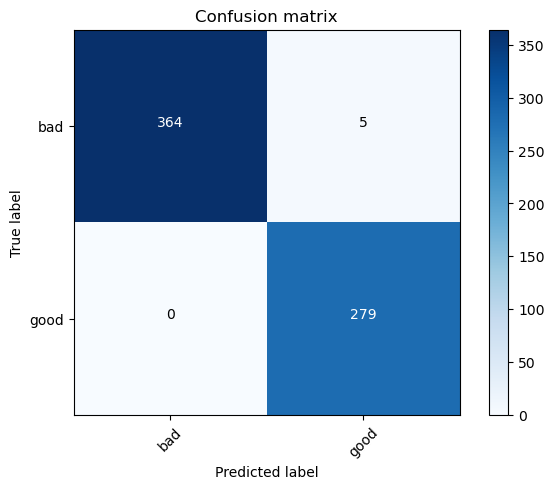